# Portfolio Construction

In this notebook we will be constructing a mean reverting portfolio of assets. We will construct a synthetic mean reverting price series consisting of weighted combinations of a basket of assets.

To construct such a portfolio we will make use of the of the open source package [Bayesian-Optimization](https://github.com/fmfn/BayesianOptimization) to perform global optimization using [Gaussian processes](https://en.wikipedia.org/wiki/Bayesian_optimization). We will be optimizing the [Hurst exponent](https://en.wikipedia.org/wiki/Hurst_exponent) in one example, and the [ADF test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) in the second example.

As a third approach we will also explore using [the Johansen test](https://en.wikipedia.org/wiki/Johansen_test) which tests for cointegration for multiple time series and also determines the proper hedge ratio for the mean reverting portfolio.

In [41]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
from bayes_opt import BayesianOptimization
from sklearn import linear_model

In [3]:
style.use('seaborn-whitegrid')

## Data

For the purpose of this project we will use cryptocurrency data from Poloniex. I have selected the pairs currently available for margin trading on the Poloniex exchange because the ability to short an asset will be necessary in the strategy resulting from this study.

In [5]:
with pd.HDFStore('polo_closing_5m_margin.h5') as store:
    closes = store['closes']

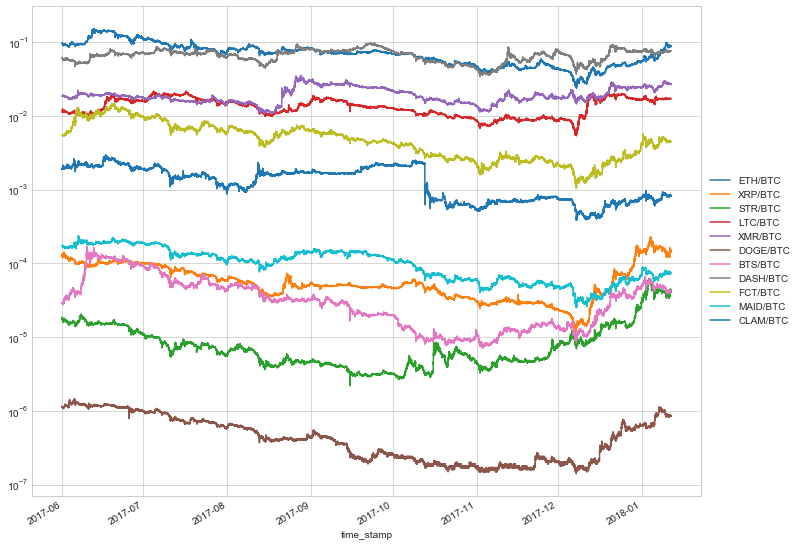

In [6]:
closes.plot(figsize=(12,10), logy=True).legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Hurst Optimization

### Hurst Calculation

In [7]:
def hurst(series):
    """
    Returns the Hurst Exponent of the time series (series)
    """

    # Check for pandas
    if type(series).__module__.split('.')[0] == pd.__name__:
        if len(series.shape) > 1:
                series = series.values[:,0]
        else:
                series = series.values
    elif not type(series).__module__.split('.')[0] == np.__name__:
        raise ValueError("""Series must by either pandas object or
                            numpy nx1 array. The series found is of
                            type {0} with name {1}""".strip().format(type(series),
                                                                     type(series).__module__))

    # Create range of lag values
    lags = np.arange(2, 100)

    # Calculate the array of variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(series[lag:], series[:-lag]))) for lag in lags]

    # use linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    return poly[0]*2

In [20]:
def generate_linear_combination(weights, data):
    if len(weights) != data.shape[1]:
        raise ValueError('The number of weights must match the number of assets.')
    weights = np.asanyarray(weights)
    return data.multiply(weights).sum(axis=1)

In [21]:
def optimize_func(weights, data):
    if len(weights) != data.shape[1]:
        raise ValueError('The number of weights must match the number of assets.')
    agg_series = generate_linear_combination(weights, data)
    return hurst(agg_series)

#### Testing The Hurst Calculation
We can test our functions by using a value of 1 for all weights. We should expect that this would produce a price series with near random behaviour resulting in a Hurst exponent near 0.5.

In [23]:
optimize_func(np.ones(closes.shape[1]), closes)

0.4991169063645621

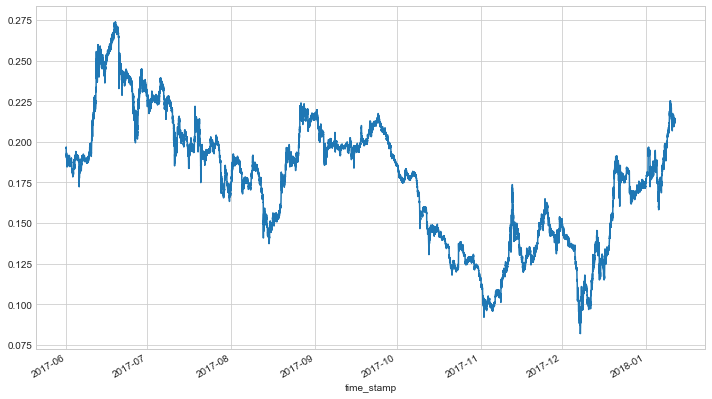

In [31]:
generate_linear_combination(np.ones(closes.shape[1]), closes).plot(figsize=(12,7));

### Bayesian Optimization

I want to take a sample of the data to run on.

In [132]:
closes.shape

(89253, 11)

In [133]:
sample_size = int(closes.shape[0] / 50)

In [134]:
closes_sample = closes.iloc[:sample_size,:]

For the optimization we will need to first estabolish upper and lower bounds. I will take a guess using a beta calculated between the price series of the two pairs with the largets difference in price.

In [40]:
sorted_pairs = closes.iloc[0,:].sort_values().index
max_pair = sorted_pairs[-1]
min_pair = sorted_pairs[0]

In [42]:
regr = linear_model.LinearRegression()
regr.fit(closes.loc[:,min_pair].values[:, np.newaxis], closes.loc[:,max_pair].values[:, np.newaxis])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
beta = regr.coef_[0][0]

In [46]:
beta

67523.58375860011

I am going to assume an upper bound of $10 * beta$ and a lower bound of $-10 * beta$.

We also need to be able to construct a **lambda** function with a **dynamic number of parameters** based on the number of pairs that we have.

In [60]:
s = "lambda "
beta_vars = ['beta_{}'.format(x) for x in np.arange(closes.shape[1])]
s += ','.join(beta_vars)
s += ': (-1)*{0}([{1}], {2})'.format(optimize_func.__name__, ','.join(beta_vars), 'closes')
s

'lambda beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10: optimize_func([beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10], closes)'

In [110]:
list(closes.columns)

['ETH/BTC',
 'XRP/BTC',
 'STR/BTC',
 'LTC/BTC',
 'XMR/BTC',
 'DOGE/BTC',
 'BTS/BTC',
 'DASH/BTC',
 'FCT/BTC',
 'MAID/BTC',
 'CLAM/BTC']

In [135]:
def run_hurst_optimization(data):
    # we will use `eval()` to generate a dynamic lambda function
    # this is a temporary solution, I don't like using eval here
    f = lambda x: optimize_func(x, data)
    s = "lambda "
#     beta_vars = ['beta_{}'.format(x) for x in np.arange(data.shape[1])]
    beta_vars = [val.split('/')[0] for val in data.columns]
    joined_beta_vars = ','.join(beta_vars)
    s += joined_beta_vars
    # we will multipy by (-1) because we will have to maximize the func
    # the hurst exponent [0,1] where 0 is mean reverting and 1 is trending
    s += ': (-1)*f([{0}])'.format(joined_beta_vars)
    opt_func = eval(s,{'f':f})  # this process should be replaced by a better dynamic lambda option
    
#     opt_func = lambda eval(joined_beta_vars): f(eval(joined_beta_vars))
    
    # generate max and min vals
    sorted_pairs = data.iloc[0,:].sort_values().index
    max_pair = sorted_pairs[-1]
    min_pair = sorted_pairs[0]
    regr = linear_model.LinearRegression()
    regr.fit(data.loc[:,min_pair].values[:, np.newaxis], data.loc[:,max_pair].values[:, np.newaxis])
    beta = regr.coef_[0][0]
    
    beta_max = 0.001*beta
    beta_min = -0.001*beta
    
#     beta_max = 1
#     beta_min = -1
    
    # set up the optimization
    bo = BayesianOptimization(opt_func, {b:(beta_min, beta_max) for b in beta_vars})
    bo.maximize(init_points=100, n_iter=15, acq='ucb')
    return bo

In [146]:
def plot_bo_result(bo, data):
    max_params = bo.res['max']['max_params']
    params_list = []
    for val in data.columns:
        params_list.append(max_params[val.split('/')[0]])
    mr = data.multiply(params_list).sum(axis=1)
    mr.plot(figsize=(10,7))
    mr.rolling(50).mean().plot()

In [126]:
bo = run_hurst_optimization(closes)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |       BTS |      CLAM |      DASH |      DOGE |       ETH |       FCT |       LTC |      MAID |       STR |       XMR |       XRP | 
    1 | 00m00s |   -0.43225 |   -7.0132 |  -62.1256 |  -25.2819 |    9.1806 |   -4.5875 |   52.0276 |  -37.4220 |    3.5597 |   55.4325 |   34.6309 |  -24.1717 | 
    2 | 00m00s |   -0.42012 |   42.6022 |   23.3748 |  -55.2210 |  -23.4062 |   49.4678 |   22.6640 |   29.5759 |  -14.4749 |   45.0467 |  -58.8749 |   48.8932 | 
    3 | 00m00s |   -0.43917 |   47.8191 |   -6.9748 |   14.3754 |   39.0135 |   26.6493 |  -46.6425 |  -60.6489 |  -56.8746 |    6.7940 |  -26.5494 |  -40.4968 | 
    4 | 00m00s |   -0.43118 |   -9.9393 |  -13.1506 |   65.9411 |  -45.9153 |  -23.9262 |   54.3686 |   14.5962 |  -55.7040 |   -6.7522 |   -4.3347 |   23.2467 | 
    5 | 

   47 | 00m00s |   -0.44719 |   55.5145 |   66.1350 |  -20.9410 |  -21.2680 |  -26.0306 |   46.0138 |   16.4560 |  -43.6567 |    1.4704 |   33.6488 |   -9.8515 | 
   48 | 00m00s |   -0.44752 |   47.1442 |  -24.7398 |   17.9937 |  -46.4063 |   42.0365 |  -35.7077 |  -32.6025 |  -40.0343 |  -26.5415 |  -53.4198 |  -42.6227 | 
   49 | 00m00s |   -0.48470 |  -55.6039 |  -25.2775 |  -47.6531 |   62.2789 |  -66.5613 |  -56.0440 |   24.6632 |   32.8662 |   45.3803 |    5.7664 |  -43.3960 | 
   50 | 00m00s |   -0.45016 |   61.7809 |  -67.4158 |  -39.3102 |  -35.6028 |  -23.8906 |  -10.5307 |   -9.3642 |  -12.7937 |  -44.7914 |   66.1239 |  -56.2237 | 
Bayesian Optimization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |       BTS |      CLAM |      DASH |      DOGE |       ETH |       FCT |       LTC |      MAID |       STR |       XMR |       XRP | 
 

/Users/kennethpotts/anaconda3/envs/ccxt_new/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.96122286e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


   63 | 00m15s |   -0.44664 |   61.3881 |  -54.7742 |   13.0551 |   60.8582 |   40.3158 |   63.1879 |  -53.7024 |  -63.8684 |  -57.3007 |  -64.5850 |  -63.1331 | 


/Users/kennethpotts/anaconda3/envs/ccxt_new/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.65423379e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   64 | 00m16s |   -0.41437 |  -45.0755 |   48.9307 |  -59.0093 |  -39.1891 |   61.5000 |  -54.7186 |   35.0928 |  -61.8554 |  -55.2991 |   49.1099 |   65.8936 | 
   65 | 00m16s |   -0.41208 |  -53.5558 |   62.1227 |   57.6529 |   66.9802 |  -36.5793 |  -55.3035 |  -10.0065 |   65.8764 |  -20.6782 |  -13.7957 |  -61.2353 | 
   66 | 00m15s |   -0.43038 |  -53.9509 |   64.3277 |  -65.9269 |   52.5396 |   45.7176 |   57.2401 |  -40.2882 |  -58.1557 |   61.3527 |  -66.1535 |  -59.6078 | 
   67 | 00m16s |   -0.41438 |   60.7483 |   61.6242 |   65.3576 |  -62.6601 |  -64.0501 |    8.2963 |  -22.2665 |   63.4663 |   59.5296 |  -35.9241 |   10.2554 | 


/Users/kennethpotts/anaconda3/envs/ccxt_new/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.65290821e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   68 | 00m17s |   -0.41117 |  -29.0261 |  -52.4006 |  -61.3416 |   43.2218 |   55.9746 |  -27.8221 |   47.8000 |   58.2107 |  -53.4411 |   37.9265 |  -65.5418 | 
   69 | 00m16s |   -0.39951 |  -61.6393 |   61.6269 |   58.2486 |   51.8527 |  -31.0465 |   64.8032 |  -62.7362 |  -40.5338 |   51.3455 |  -64.7466 |   46.9188 | 
   70 | 00m15s |   -0.40750 |  -39.7499 |  -37.9733 |  -61.5441 |  -67.2063 |   37.5302 |   65.5993 |   64.3916 |  -65.6606 |   51.6762 |   66.5258 |   39.5401 | 
   71 | 00m15s |   -0.41690 |   63.1141 |   63.6520 |  -53.8233 |  -64.1889 |   58.8682 |  -58.5140 |   36.4811 |  -49.1630 |   59.7773 |   61.2979 |   50.8297 | 
   72 | 00m15s |   -0.46277 |  -57.7903 |   43.8104 |  -42.0262 |  -65.9133 |  -66.9482 |   61.4994 |   59.9869 |  -39.1068 |  -66.0738 |   38.4583 |   65.9072 | 
   73 | 00m16s |   -0.41278 |   35.2800 |  -56.3762 |   66.5888 |   64.3269 |  -52.2778 |  -63.5839 |  -52.9647 |   58.4786 |  -54.8673 |  -28.8772 |  -62.8074 | 
   74 | 00m15s |   -0.

/Users/kennethpotts/anaconda3/envs/ccxt_new/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00027279]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   90 | 00m17s |   -0.41180 |  -38.5891 |  -45.0727 |  -55.4291 |  -64.7702 |   55.7602 |  -64.6419 |   57.9704 |  -57.2788 |   23.3013 |   48.5040 |  -66.7761 | 


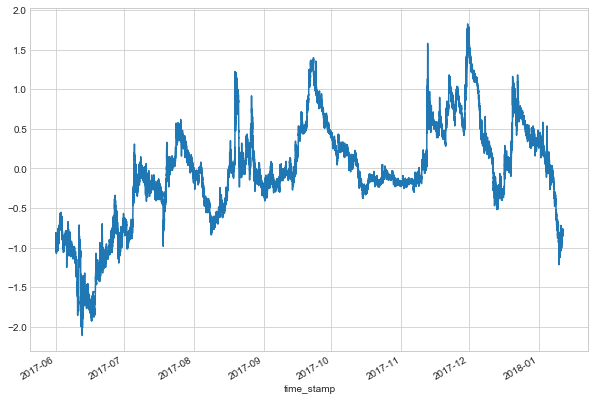

In [127]:
plot_bo_result(bo, closes)

In [136]:
bo_sample = run_hurst_optimization(closes_sample)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |       BTS |      CLAM |      DASH |      DOGE |       ETH |       FCT |       LTC |      MAID |       STR |       XMR |       XRP | 
    1 | 00m00s |   -0.36864 |    0.2595 |   -1.9311 |   -5.0234 |   -6.4134 |    4.5389 |   -0.4972 |   -2.9050 |    2.6259 |    8.1245 |   -0.4437 |    7.4649 | 
    2 | 00m00s |   -0.45456 |    0.1582 |    6.1357 |    3.4757 |    3.0592 |    3.3305 |    7.3277 |    0.0452 |    4.1577 |    6.6029 |    4.2804 |   -1.8737 | 
    3 | 00m00s |   -0.44922 |   -7.6545 |    5.0572 |    6.9803 |   -3.7928 |    6.9443 |    4.7744 |   -2.1600 |   -3.8723 |    2.1556 |    1.0595 |   -4.1335 | 
    4 | 00m00s |   -0.43208 |   -5.3489 |    6.2125 |   -5.2662 |   -4.4139 |   -3.7878 |   -7.3128 |    6.2178 |   -1.7009 |   -0.5073 |   -5.2536 |    3.5161 | 
    5 | 

   50 | 00m00s |   -0.47537 |   -3.8328 |   -1.4291 |    0.9333 |    2.1923 |    0.7464 |    3.8490 |   -0.5035 |    6.3868 |    5.7430 |   -1.3242 |    1.2001 | 
   51 | 00m00s |   -0.42417 |    4.7117 |    1.7520 |    3.7051 |   -6.5394 |   -5.3458 |   -0.4810 |   -7.7588 |   -6.2593 |    3.9044 |    8.2142 |   -3.8683 | 
   52 | 00m00s |   -0.43404 |   -4.1858 |   -4.2977 |   -2.0475 |   -7.4609 |   -8.0971 |    6.9619 |   -2.0940 |   -2.6230 |   -3.1232 |    0.3170 |    5.5626 | 
   53 | 00m00s |   -0.44199 |    8.2330 |    4.8252 |    4.3325 |   -2.2046 |    6.2694 |   -1.3819 |    6.3092 |   -1.5747 |    2.0652 |    4.7116 |    5.1637 | 
   54 | 00m00s |   -0.41900 |    5.3168 |   -2.4396 |    0.9130 |   -4.8585 |   -1.5398 |    8.1145 |   -6.2103 |    7.2658 |    5.5081 |   -6.5491 |   -0.6662 | 
   55 | 00m00s |   -0.43546 |    7.4609 |    3.4353 |   -0.2647 |   -5.9622 |   -5.4478 |   -2.0898 |   -0.5347 |   -1.7473 |   -2.9825 |   -4.2828 |   -1.4272 | 
   56 | 00m00s |   -0.

Bayesian Optimization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |       BTS |      CLAM |      DASH |      DOGE |       ETH |       FCT |       LTC |      MAID |       STR |       XMR |       XRP | 
  101 | 00m24s |   -0.39174 |   -2.6348 |   -8.2705 |   -7.0197 |   -6.9575 |    7.4121 |   -4.7919 |    7.2554 |   -7.9770 |    4.9787 |   -6.5305 |   -7.3938 | 
  102 | 00m23s |   -0.39281 |   -8.2913 |   -8.2913 |   -8.2913 |    8.2913 |    8.2913 |    8.2913 |    8.2913 |   -8.2913 |   -8.2913 |   -8.2913 |   -8.2913 | 
  103 | 00m23s |   -0.33876 |    4.3413 |    7.4727 |    6.2501 |    8.0715 |    0.1188 |   -6.8150 |   -7.5179 |    2.0694 |    5.8322 |    7.5871 |   -7.0098 | 
  104 | 00m24s |   -0.38645 |    8.2913 |    8.2913 |    8.2913 |    8.2913 |   -8.2913 |   -8.2913 |   -8.2913 |   -8.2913 |    8.2913 |   -8.2913 |    8.2913 | 
 

/Users/kennethpotts/anaconda3/envs/ccxt_new/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.53732411e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


  111 | 00m24s |   -0.38303 |   -8.2823 |   -8.2775 |    8.2913 |    3.3134 |   -8.2739 |    7.4652 |    8.2913 |   -8.2913 |   -8.2913 |    8.2913 |   -5.6940 | 
  112 | 00m24s |   -0.38151 |   -6.2350 |   -7.8123 |   -6.9921 |   -1.0274 |    6.5761 |    4.8853 |    4.3185 |   -3.7586 |    8.2777 |    8.1554 |   -7.7570 | 
  113 | 00m24s |   -0.39338 |   -8.2913 |   -7.0441 |   -7.8332 |   -8.2913 |    8.2913 |   -8.2005 |   -8.2913 |   -8.2913 |    8.2913 |    7.5296 |    4.4934 | 
  114 | 00m24s |   -0.37009 |   -3.3740 |    8.2913 |   -8.2913 |   -8.2913 |    8.2799 |    6.5755 |   -5.6383 |   -8.2913 |    8.2913 |    0.3268 |    6.6748 | 
  115 | 00m23s |   -0.37431 |    8.1449 |   -8.1802 |   -7.8168 |    0.4196 |    7.8185 |    5.8018 |   -4.4769 |    6.7324 |    1.2188 |    6.2827 |   -8.2811 | 


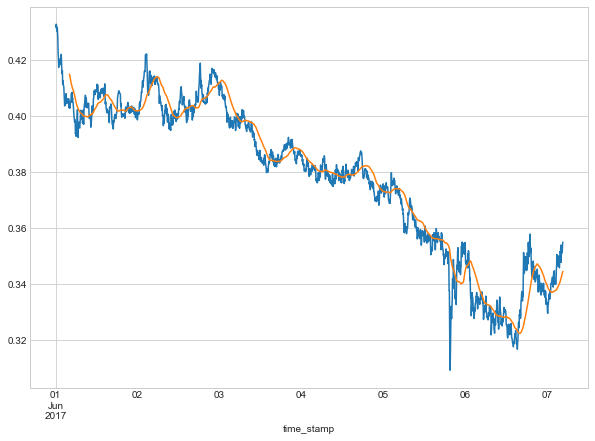

In [147]:
plot_bo_result(bo_sample, closes_sample)

In [148]:
bo_sample.res['max']

{'max_params': {'BTS': 4.341305093882946,
  'CLAM': 7.4726633346794245,
  'DASH': 6.250149971595535,
  'DOGE': 8.071461269749111,
  'ETH': 0.1188390121950853,
  'FCT': -6.814978780367404,
  'LTC': -7.517867826867343,
  'MAID': 2.0694293463150313,
  'STR': 5.832169962417902,
  'XMR': 7.587063283971403,
  'XRP': -7.009795171482394},
 'max_val': -0.338759510016941}